<h1><center> PEMODELAN DAN PERAMALAN DERET WAKTU</center></h1><center>Laily Nissa A. Mualifah </center>

<center>
_____________________________________________________________________________________________________________________________
</center>


In [1]:
!pip install PythonTsa

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from PythonTsa.plot_acf_pacf import acf_pacf_fig
from scipy.stats import boxcox,  boxcox_llf

import warnings
warnings.filterwarnings("ignore")

Untuk ilustrasi deret stasioner digunakan indeks rata-rata bulanan osilasi Atlantik Utara (NAO) sejak Januari 1950 sampai Maret 2025.

In [3]:
link = "https://ftp.cpc.ncep.noaa.gov/cwlinks/norm.daily.nao.cdas.z500.19500101_current.csv"
nao=pd.read_csv(link)

In [4]:
nao.head()

,year,month,day,nao_index_cdas
0,1950,1,1,0.365
1,1950,1,2,0.096
2,1950,1,3,-0.416
3,1950,1,4,-0.616
4,1950,1,5,-0.261


In [5]:
nao.tail()

,year,month,day,nao_index_cdas
27451,2025,2,27,1.656352
27452,2025,2,28,1.740678
27453,2025,3,1,1.827419
27454,2025,3,2,1.465855
27455,2025,3,3,1.186775


In [6]:
#cek missing values
nao.isnull().sum()

,0
year,0
month,0
day,0
nao_index_cdas,2


In [7]:
#imputasi missing values
nao.fillna(0,inplace=True)

In [8]:
#cek missing values
nao.isnull().sum()

,0
year,0
month,0
day,0
nao_index_cdas,0


In [9]:
#agregasi data sebagai nilai rata-rata bulanan
naos=nao.groupby(['year','month'])['nao_index_cdas'].mean()

In [10]:
timeindex=pd.date_range('1950-01', periods=len(naos),freq='M')

In [11]:
naos.index=timeindex

In [12]:
naos.tail()

,nao_index_cdas
2024-11-30,-0.079274
2024-12-31,0.441839
2025-01-31,-0.229090
2025-02-28,0.942348
2025-03-31,1.493350


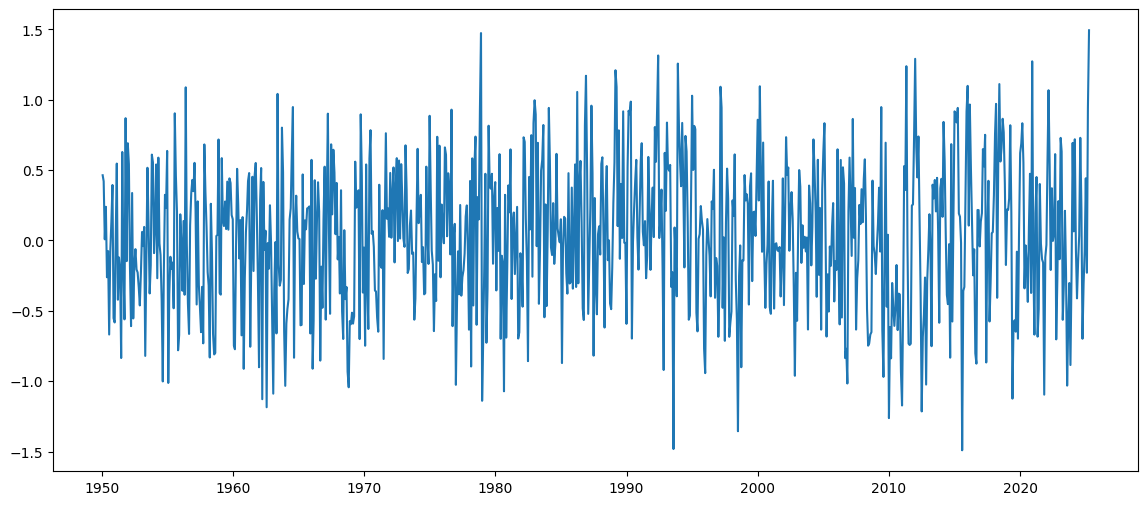

In [13]:
#plot deret waktu
plt.figure(figsize=(14,6))
plt.plot(naos); plt.show()

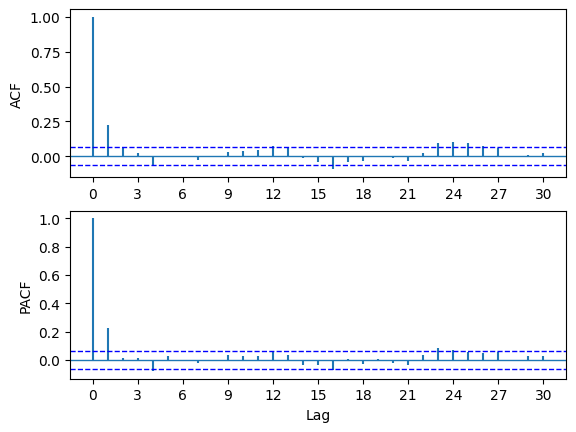

In [14]:
#plot acf dan pacf contoh
acf_pacf_fig(naos, both=True, lag=30); plt.show()

In [15]:
from statsmodels.tsa.stattools import adfuller
adfuller(naos, autolag='AIC')[1]

0.0

Proses eksplorasi deret secara detail sudah dibahas pada perkuliahan minggu ke-4. Berdasarkan plot ACF dan PACF contoh tampak bahwa lag yang signifikan adalah lag 1 (baik dari ACF maupun PACF). Sehingga model yang bisa dicobakan adalah model AR (1), atau MA (1). Alat bantu identifikasi model yang lainnya adalah EACF.

In [16]:
!pip install rpy2

In [17]:
import warnings
warnings.filterwarnings("ignore")

#Jalankan syntax ini cukup satu kali, jangan berulang
%load_ext rpy2.ipython

In [18]:
%%R
install.packages('TSA')
library (TSA)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/TSA_1.3.1.tar.gz'
Content type 'application/x-gzip' length 207505 bytes (202 KB)
downloaded 202 KB


The downloaded source packages are in
	‘/tmp/Rtmpyqv3PP/downloaded_packages’

Attaching package: ‘TSA’

The following objects are masked from ‘package:stats’:

    acf, arima

The following object is masked from ‘package:utils’:

    tar



In [19]:
%%R -i naos
#membuat plot EACF dari data naos
eacf(as.numeric(naos))

AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 x o o o o o o o o o o  x  o  o 
1 o o o x o o o o o o o  o  o  o 
2 x o x x o o o o o o o  o  o  o 
3 x x x x o o o o o o o  o  o  o 
4 x o x o o o o o o o o  o  o  o 
5 x o x x x x o o o o o  o  o  o 
6 x x o o x o o o o o o  o  o  o 
7 x x x o x x o o o o o  o  o  o 


In [20]:
#model MA (1)
model_ma1=ARIMA(naos,order=(0,0,1)).fit()

In [21]:
print(model_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:         nao_index_cdas   No. Observations:                  903
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -657.406
Date:                Thu, 06 Mar 2025   AIC                           1320.812
Time:                        04:06:04   BIC                           1335.229
Sample:                    01-31-1950   HQIC                          1326.319
                         - 03-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0291      0.020      1.433      0.152      -0.011       0.069
ma.L1          0.2145      0.032      6.611      0.000       0.151       0.278
sigma2         0.2511      0.013     19.383      0.0

Perhatikan hasil fitting model MA (1) di atas. Penduga parameter untuk komponen MA yaitu $(\theta_1)$ signifikan.

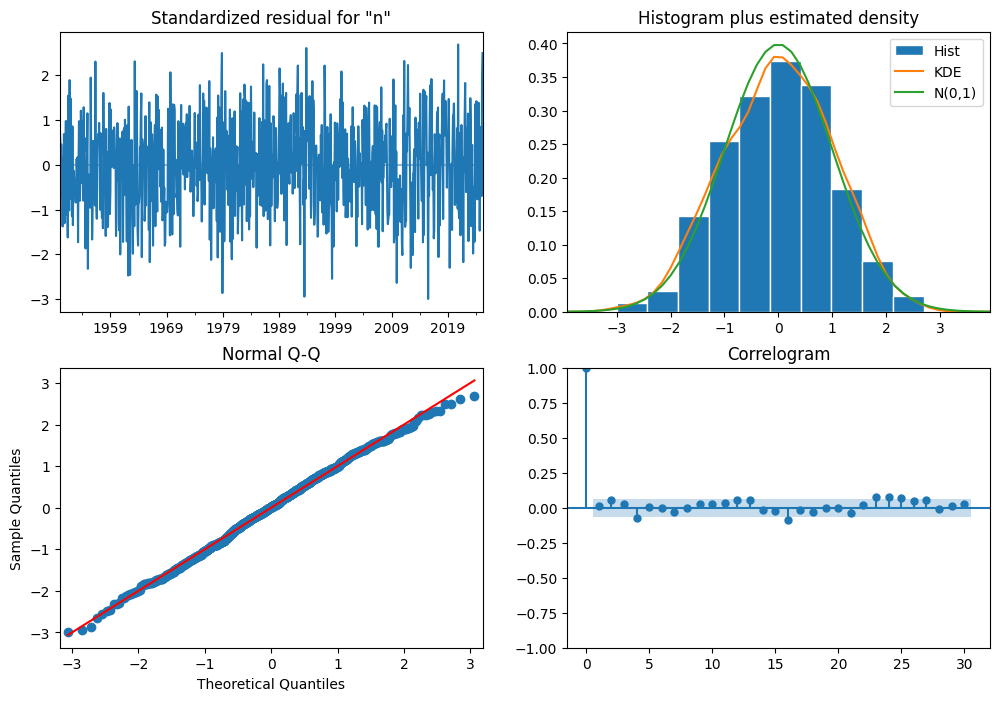

In [22]:
#Analisis Sisaan Model
model_ma1.plot_diagnostics(figsize=(12,8), lags=30)
plt.show()

In [23]:
model_ma1.test_heteroskedasticity('breakvar')

array([[1.17585976, 0.16050913]])

In [24]:
from statsmodels.stats.diagnostic import het_arch
het_arch(model_ma1.resid, nlags=30)[1]

0.6498623726520935

In [25]:
from statsmodels.sandbox.stats.runs import runstest_1samp
runstest_1samp(model_ma1.resid, correction=False)

(-0.6297070931794864, 0.5288862408717612)

In [26]:
from scipy.stats import shapiro
stat,p = shapiro(model_ma1.resid)
print(stat,p)

0.9971033957869283 0.10438596251923166


In [27]:
from scipy.stats import jarque_bera

jb_stat, jb_pval = jarque_bera(model_ma1.resid)
print(jb_stat, jb_pval)

5.251800376630736 0.07237457695297643


Apakah model MA (1) sudah memenuhi asumsi model?

Model lain yang dicobakan adalah AR (1)

In [28]:
#model AR (1)
model_ar1=ARIMA(naos,order=(1,0,0)).fit()

In [29]:
print(model_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:         nao_index_cdas   No. Observations:                  903
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -656.109
Date:                Thu, 06 Mar 2025   AIC                           1318.218
Time:                        04:06:06   BIC                           1332.635
Sample:                    01-31-1950   HQIC                          1323.724
                         - 03-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0293      0.022      1.360      0.174      -0.013       0.072
ar.L1          0.2248      0.032      7.043      0.000       0.162       0.287
sigma2         0.2504      0.013     19.383      0.0

Hasil fitting model AR (1) menunjukkan penduga parameter untuk komponen AR yaitu $(\phi_1)$ signifikan.

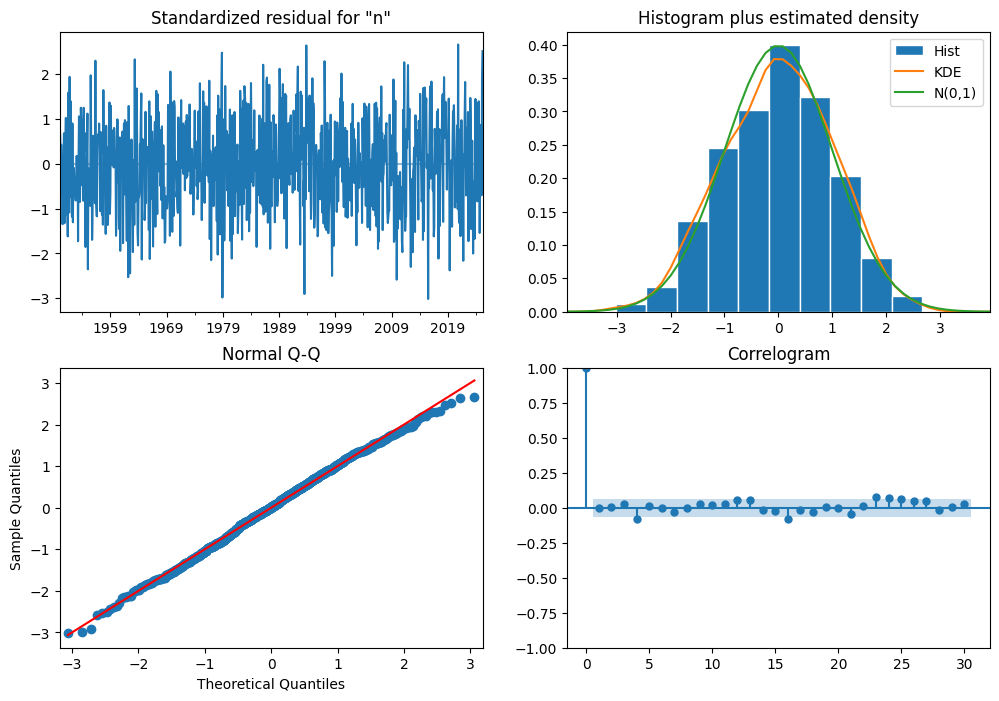

In [30]:
#Analisis Sisaan Model
model_ar1.plot_diagnostics(figsize=(12,8), lags=30)
plt.show()

In [31]:
model_ar1.test_heteroskedasticity('breakvar')

array([[1.15990364, 0.19875094]])

In [32]:
from statsmodels.stats.diagnostic import het_arch
het_arch(model_ar1.resid, nlags=30)[1]

0.6820889765107838

In [33]:
from statsmodels.sandbox.stats.runs import runstest_1samp
runstest_1samp(model_ar1.resid, correction=False)

(-0.6308623610618588, 0.5281305240557053)

In [34]:
from scipy.stats import shapiro
stat,p = shapiro(model_ar1.resid)
print(stat,p)

0.9971008565072443 0.10399523206862671


In [35]:
from scipy.stats import jarque_bera

jb_stat, jb_pval = jarque_bera(model_ar1.resid)
print(jb_stat, jb_pval)

5.437983874174267 0.06594119380514499


Apakah model AR (1) sudah memenuhi asumsi model?

Selanjutnya ditentukan model terbaik antara model MA (1) dan AR (1). Pemilihan model terbaik bisa berdasarkan beberapa kriteria, misalnya nilai AIC dan BIC model.

In [36]:
pd.DataFrame({'Model':['MA(1)','AR(1)'],
            'AIC':[model_ma1.aic,model_ar1.aic],
            'BIC':[model_ma1.bic,model_ar1.bic]})

,Model,AIC,BIC
0,MA(1),1320.812141,1335.229309
1,AR(1),1318.217511,1332.634679


Berdasarkan nilai AIC dan BIC model yang lebih baik adalah model AR (1). Selanjutnya dilakukan overfitting model dengan mencobakan model AR (2).

In [37]:
#model AR (2)
model_ar2=ARIMA(naos,order=(2,0,0)).fit()

In [38]:
print(model_ar2.summary())

                               SARIMAX Results                                
Dep. Variable:         nao_index_cdas   No. Observations:                  903
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -656.051
Date:                Thu, 06 Mar 2025   AIC                           1320.102
Time:                        04:06:08   BIC                           1339.325
Sample:                    01-31-1950   HQIC                          1327.444
                         - 03-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0294      0.022      1.346      0.178      -0.013       0.072
ar.L1          0.2223      0.033      6.718      0.000       0.157       0.287
ar.L2          0.0114      0.035      0.326      0.7

In [39]:
#model ARMA (1,1)
model_arma11=ARIMA(naos,order=(1,0,1)).fit()

In [40]:
print(model_arma11.summary())

                               SARIMAX Results                                
Dep. Variable:         nao_index_cdas   No. Observations:                  903
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -656.048
Date:                Thu, 06 Mar 2025   AIC                           1320.096
Time:                        04:06:08   BIC                           1339.319
Sample:                    01-31-1950   HQIC                          1327.438
                         - 03-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0294      0.022      1.344      0.179      -0.013       0.072
ar.L1          0.2755      0.148      1.862      0.063      -0.014       0.565
ma.L1         -0.0534      0.155     -0.345      0.7

Hasil fitting model AR (2) maupun model ARMA (1,1) memberikan hasil bahwa penduga parameter untuk komponen AR yaitu $(\phi_2)$ dan komponen MA yaitu $(\theta_1)$ tidak signifikan, sehingga model AR (2) atau ARMA (1,1) tidak lebih baik daripada model AR (1).

In [41]:
prediksi=model_ar1.get_forecast(12).summary_frame(alpha=0.05)

In [42]:
prediksi

nao_index_cdas,mean,mean_se,mean_ci_lower,mean_ci_upper
2025-04-30,0.358406,0.500379,-0.622319,1.339130
2025-05-31,0.103306,0.512863,-0.901887,1.108498
2025-06-30,0.045967,0.513485,-0.960445,1.052380
2025-07-31,0.033080,0.513517,-0.973395,1.039554
2025-08-31,0.030183,0.513518,-0.976295,1.036660
2025-09-30,0.029532,0.513519,-0.976946,1.036010
2025-10-31,0.029385,0.513519,-0.977093,1.035863
2025-11-30,0.029352,0.513519,-0.977125,1.035830
2025-12-31,0.029345,0.513519,-0.977133,1.035823
2026-01-31,0.029343,0.513519,-0.977134,1.035821


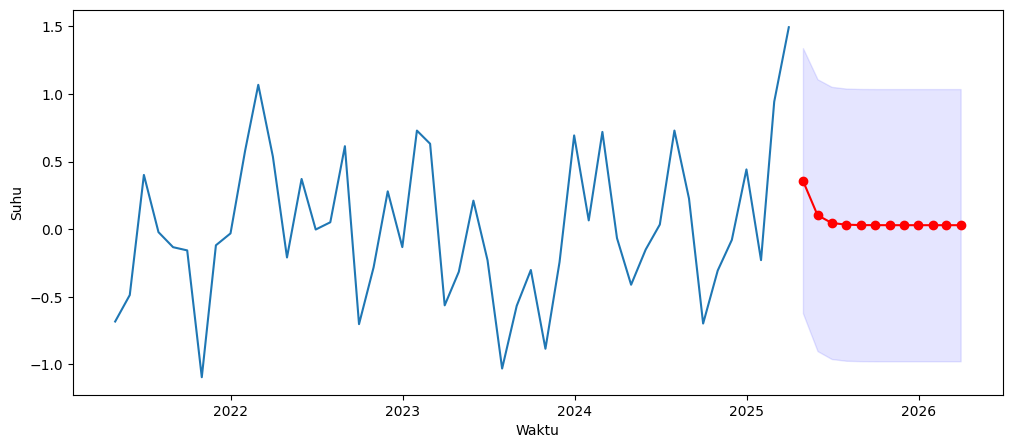

In [43]:
plt.figure(figsize=(12,5))
plt.plot(naos[-48:])
plt.plot(prediksi['mean'],'-or')
plt.fill_between(prediksi.index,prediksi['mean_ci_lower'], prediksi['mean_ci_upper'], color='b', alpha=.1)
plt.xlabel('Waktu'), plt.ylabel('Suhu')
plt.show()

<h2> Pemodelan dengan Pembagian Data Training dan Testing </h2>

In [44]:
#pembagian data training testing
size_train=round(0.9*naos.shape[0])
train, test=naos[:size_train], naos[size_train:]

In [45]:
train

,nao_index_cdas
1950-01-31,0.463516
1950-02-28,0.420714
1950-03-31,0.008387
1950-04-30,0.239433
1950-05-31,-0.261226
...,...
2017-05-31,-0.866560
2017-06-30,0.060908
2017-07-31,0.424050
2017-08-31,-0.575282


In [46]:
test

,nao_index_cdas
2017-10-31,0.051423
2017-11-30,0.060257
2017-12-31,0.322819
2018-01-31,0.757953
2018-02-28,0.970378
...,...
2024-11-30,-0.079274
2024-12-31,0.441839
2025-01-31,-0.229090
2025-02-28,0.942348


In [47]:
adfuller(train, autolag='AIC')[1]

0.0

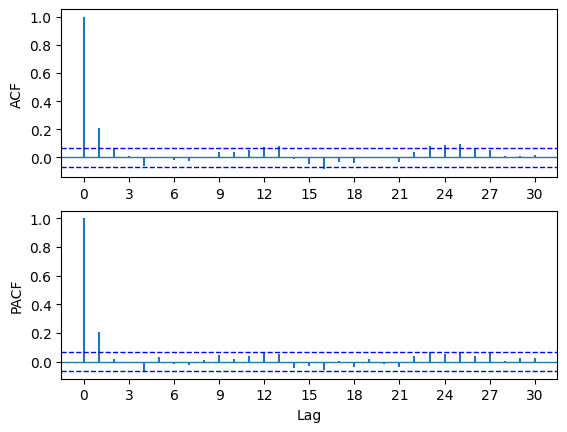

In [48]:
acf_pacf_fig(train, both=True, lag=30); plt.show()

In [49]:
#model MA (1)
train_ma1=ARIMA(train,order=(0,0,1)).fit()

In [50]:
print(train_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:         nao_index_cdas   No. Observations:                  813
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -585.557
Date:                Thu, 06 Mar 2025   AIC                           1177.114
Time:                        04:06:09   BIC                           1191.216
Sample:                    01-31-1950   HQIC                          1182.528
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0218      0.021      1.040      0.298      -0.019       0.063
ma.L1          0.1956      0.034      5.721      0.000       0.129       0.263
sigma2         0.2472      0.013     18.353      0.0

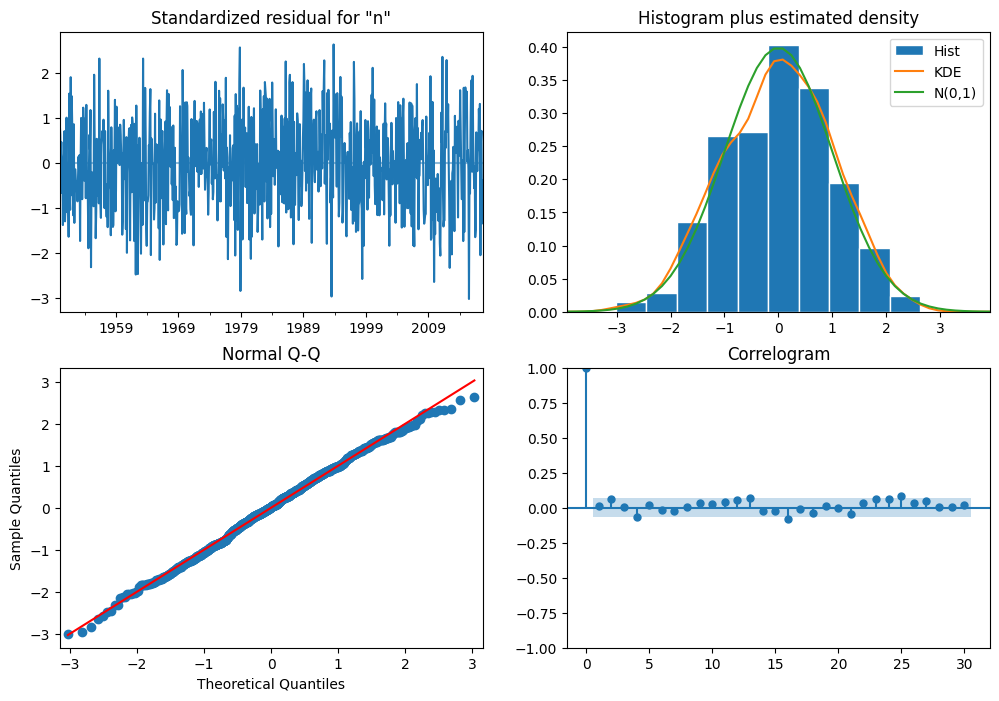

In [51]:
train_ma1.plot_diagnostics(figsize=(12,8), lags=30); plt.show()

In [52]:
het_arch(train_ma1.resid, nlags=30)[1]

0.3844090730108126

In [53]:
runstest_1samp(train_ma1.resid, correction=False)

(-0.8000523077531969, 0.4236804915724085)

In [54]:
stat,p = shapiro(train_ma1.resid)
print(stat,p)

0.9965675581059388 0.0758256683789741


In [55]:
train_ar1=ARIMA(train,order=(1,0,0)).fit()

In [56]:
print(train_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:         nao_index_cdas   No. Observations:                  813
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -584.199
Date:                Thu, 06 Mar 2025   AIC                           1174.397
Time:                        04:06:10   BIC                           1188.499
Sample:                    01-31-1950   HQIC                          1179.810
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0218      0.022      0.983      0.326      -0.022       0.065
ar.L1          0.2098      0.033      6.333      0.000       0.145       0.275
sigma2         0.2464      0.013     18.353      0.0

In [57]:
het_arch(train_ar1.resid, nlags=30)[1]

0.3944199523746366

In [58]:
runstest_1samp(train_ar1.resid, correction=False)

(-0.9441344457405356, 0.34510094905316835)

In [59]:
stat,p = shapiro(train_ar1.resid)
print(stat,p)

0.9966812455319551 0.08834389914798894


In [60]:
pd.DataFrame({'Model':['MA(1)','AR(1)'],
            'AIC':[train_ma1.aic,train_ar1.aic],
            'BIC':[train_ma1.bic,train_ar1.bic]})

,Model,AIC,BIC
0,MA(1),1177.114213,1191.216407
1,AR(1),1174.397079,1188.499272


In [61]:
prediksi_test=train_ar1.get_forecast(test.shape[0]).summary_frame(alpha=0.05)

In [62]:
prediksi_test

nao_index_cdas,mean,mean_se,mean_ci_lower,mean_ci_upper
2017-10-31,-0.045865,0.496383,-1.018758,0.927028
2017-11-30,0.007566,0.507194,-0.986515,1.001647
2017-12-31,0.018777,0.507664,-0.976226,1.013781
2018-01-31,0.021130,0.507685,-0.973914,1.016174
2018-02-28,0.021624,0.507686,-0.973422,1.016670
...,...,...,...,...
2024-11-30,0.021755,0.507686,-0.973291,1.016801
2024-12-31,0.021755,0.507686,-0.973291,1.016801
2025-01-31,0.021755,0.507686,-0.973291,1.016801
2025-02-28,0.021755,0.507686,-0.973291,1.016801


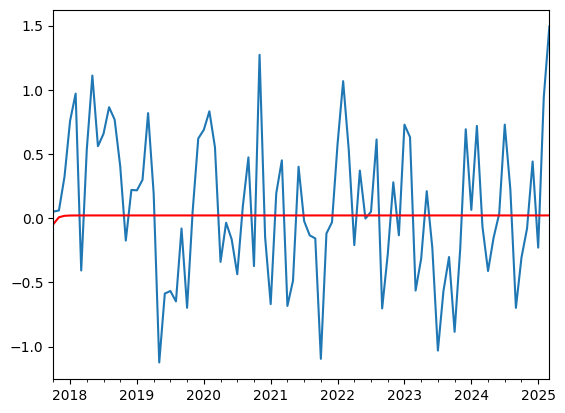

In [63]:
test.plot()
prediksi_test['mean'].plot(color='red')
plt.show()

In [64]:
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error
print('MAPE: ',mean_absolute_percentage_error(test,prediksi_test['mean'])*100, '%')
print('MSE: ',mean_squared_error(test,prediksi_test['mean']))
print('MAE: ',mean_absolute_error(test,prediksi_test['mean']))

MAPE:  111.76506993812507 %
MSE:  0.31697095457128754
MAE:  0.46048831943356916


Perhatikan bahwa nilai MAPE yang sangat besar. Berdasarkan plot perbandingan antara data test dan hasil prediksi tampak pola hasil prediksi hampir konstan sementara nilai data test sangat fluktiatif, yang berarti bahwa nilai hasil prediksi sangat jauh dari data test. Sedangkan nilai MSE dan MAE sangat kecil. Nilai MSE dan MAE akan relatif terhadap satuan data yang digunakan. Karena data naos dalam skala $10^{-1}$ sehingga nilai MSE dan MAE akan mengikuti skala tersebut. Nilai MSE dan MAE yang kecil tidak berarti bahwa errornya kecil.

##TUGAS INDIVIDU

Lakukan Pemodelan hingga peramalan untuk deret waktu harga bulanan satu barel minyak mentah dari Januari 1986 sampai Januari 2006. Data dapat diakses dengan sintaks sebagai berikut.

- Setiap individu menambah data dengan angka berupa 2 kali dari dua digit terakhir NIM, misal digit terakhir NIM 07, maka setiap baris dari data ditambah dengan $2 \times 7=14$

- Lakukan pembagian data latih dan data uji untuk pemodelan (pembagian data mengikuti pola dari data, bukan berdasarkan proporsi)

- Hitung nilai kebaikan model berdasarkan MAPE pada data uji

In [65]:
link = "http://homepage.divms.uiowa.edu/~kchan/TSA/Datasets/oil.price.dat"
oil=pd.read_csv(link,delimiter='\t')
oil.columns=['minyak']

In [66]:
oil.head()

,minyak
0,22.93
1,15.45
2,12.61
3,12.84
4,15.38
